In [135]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

### Load MNIST

In [85]:
mnist = tfds.image.MNIST()

# Describe the dataset with DatasetInfo
assert mnist.info.features['image'].shape == (28, 28, 1)
assert mnist.info.features['label'].num_classes == 10
assert mnist.info.splits['train'].num_examples == 60000

# Download the data, prepare it, and write it to disk
mnist.download_and_prepare()

mnist_dataset = mnist.as_dataset(batch_size=-1)

x_train = mnist_dataset['train']['image']
y_train = mnist_dataset['train']['label']
x_test  = mnist_dataset['test']['image']
y_test  = mnist_dataset['test']['label']

x_train = tf.cast(x_train, tf.float32)/255.0
x_test = tf.cast(x_test, tf.float32)/255.0

## Create and train the model

In [88]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(10)
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

train_stats = model.fit(
                x = x_train,
                y = y_train,
                shuffle=True,
                epochs=20,
                batch_size=128,
                validation_data=(x_test, y_test),
              )

Epoch 1/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4135 - sparse_categorical_accuracy: 0.8785 - val_loss: 0.1195 - val_sparse_categorical_accuracy: 0.9635
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0980 - sparse_categorical_accuracy: 0.9688 - val_loss: 0.0983 - val_sparse_categorical_accuracy: 0.9692
Epoch 3/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0644 - sparse_categorical_accuracy: 0.9786 - val_loss: 0.0829 - val_sparse_categorical_accuracy: 0.9747
Epoch 4/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0466 - sparse_categorical_accuracy: 0.9851 - val_loss: 0.0796 - val_sparse_categorical_accuracy: 0.9758
Epoch 5/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0404 - sparse_categorical_accuracy: 0.9870 - val_loss: 0.0744 - val_sparse_categorical_accuracy: 0.9764
Epoch 6/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0320 - spars

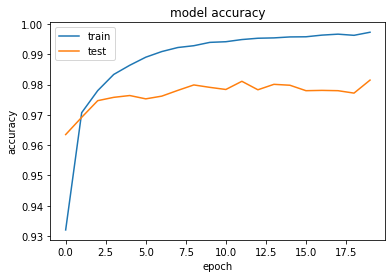

In [89]:
plt.plot(train_stats.history['sparse_categorical_accuracy'])
plt.plot(train_stats.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [94]:
predictions_test = model.predict(x_test)

In [95]:
predictions_test.shape

(10000, 10)

In [96]:
predictions_train = model.predict(x_train)

In [167]:
predictions_train

array([[-3.4611275e+01, -3.4223511e+00, -1.3501972e+01, ...,
        -6.4922123e+00, -4.6872311e+00, -6.0117249e+00],
       [-2.6383812e+01,  2.2142614e+01, -1.7067194e+01, ...,
         5.3267026e+00, -1.0082386e+01, -1.2505128e+01],
       [ 2.3907051e+01, -2.1029942e+01, -2.0591605e+00, ...,
        -1.6457083e+01, -1.3467860e+01, -6.7613406e+00],
       ...,
       [-4.5901837e+00, -2.1289085e+01, -2.2071899e+01, ...,
        -2.6665602e+01, -1.3398007e+01, -1.6343275e+01],
       [-3.7453625e+01,  2.0126869e+01, -1.4763664e+01, ...,
        -7.0933766e+00, -5.6623106e+00, -9.6061554e+00],
       [-2.9780289e+01, -3.4090279e+01, -2.9815676e+01, ...,
        -1.8679586e+01,  8.1498137e+00, -2.1983020e-02]], dtype=float32)

## Check Model

Now that the initial model is trained, we need to train our check model.
We need to 

 1. come up with an initial transformation function for x
 2. figure out what shape the check model should be (preferable smaller than initial model)
 3. train so x' -> y'

### Model 1: Let's try to simply sum up rows of pixels and learn the output from them.

In [150]:
x_train.shape

TensorShape([60000, 28, 28, 1])

In [155]:
x_train_check = np.zeros((60000,28,1), dtype=np.float32)
x_test_check = np.zeros((10000,28,1), dtype=np.float32)

In [156]:
# x_train_numpy = x_train.numpy()

In [157]:
for i in range(0,60000):
    x_train_check[i] = sum(x_train[i])

In [158]:
for i in range(0,10000):
    x_test_check[i] = sum(x_test[i])

In [162]:
x_train_check.shape

(60000, 28, 1)

In [115]:
sum(x_train[0]).shape

TensorShape([28, 1])

In [173]:
model_check = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28,1)),
  tf.keras.layers.Dense(64,activation='relu'),
  tf.keras.layers.Dense(10)
])
model_check.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

train_stats = model_check.fit(
                x = x_train_check,
                y = y_train,
                shuffle=True,
                epochs=20,
                batch_size=128,
                validation_data=(x_test_check, y_test),
              )

Epoch 1/20
469/469 [==============================] - 1s 3ms/step - loss: 2.6140 - sparse_categorical_accuracy: 0.2705 - val_loss: 1.5249 - val_sparse_categorical_accuracy: 0.4673
Epoch 2/20
469/469 [==============================] - 1s 2ms/step - loss: 1.5408 - sparse_categorical_accuracy: 0.4589 - val_loss: 1.4269 - val_sparse_categorical_accuracy: 0.5080
Epoch 3/20
469/469 [==============================] - 1s 2ms/step - loss: 1.4529 - sparse_categorical_accuracy: 0.4955 - val_loss: 1.3508 - val_sparse_categorical_accuracy: 0.5398
Epoch 4/20
469/469 [==============================] - 1s 2ms/step - loss: 1.3916 - sparse_categorical_accuracy: 0.5204 - val_loss: 1.3021 - val_sparse_categorical_accuracy: 0.5487
Epoch 5/20
469/469 [==============================] - 1s 2ms/step - loss: 1.3294 - sparse_categorical_accuracy: 0.5425 - val_loss: 1.2650 - val_sparse_categorical_accuracy: 0.5713
Epoch 6/20
469/469 [==============================] - 1s 2ms/step - loss: 1.2950 - sparse_categorica

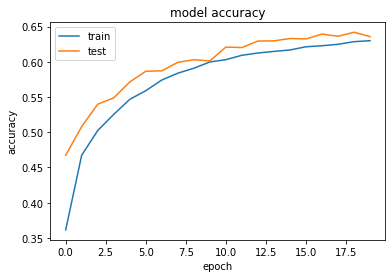

In [175]:
plt.plot(train_stats.history['sparse_categorical_accuracy'])
plt.plot(train_stats.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Results

This is basically just doing a worse, less accurate model